In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import pandas as pd
import seaborn as sns
from sklearn import linear_model
pd.set_option('display.max_rows', 40)
!date

Fri Mar 20 07:47:22 PDT 2020


# 2010 census demo data. looking for good predictors of bias seen in AIAN on-res counts and urban/rural by-county asian alone counts

Akee's talk here: https://vimeo.com/380264104

In [3]:
##Encoding of the AIANHH var:
#0001–4999 Federally recognized American Indian reservation and/or off-reservation trust land
#5000–5499 Hawaiian home land 5500–5999 Oklahoma tribal statistical area
#5500–5999 Oklahoma tribal statistical area
#6000–7999 Alaska Native village statistical area
#8000–8999 Tribal designated statistical area
#9000–9499 State-recognized American Indian reservation
#9500–9998 State designated tribal statistical area 

In [4]:
## Encoding of race vars
# White alone P0030002
# Black or African American alone P0030003
# American Indian and Alaska Native alone P0030004
# Asian alone P0030005
# Native Hawaiian and Other Pacific Islander alone P0030006 
# Some Other Race alone P0030007 
# Two or More Races P0030008 

In [5]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK']

race_cols = ['P0030001','P0030002','P0030003','P0030004','P0030005','P0030006','P0030007','P0030008'] # race vars
keep_cols = location_cols + race_cols

def my_cols(x):
    if x.startswith('P001'):
        return True
    elif x.startswith(('AIAN','AITS','TTRACT','UA','UR')):
        return True
    else:
        return (x in keep_cols)

In [6]:
%%time

df_dp = pd.read_csv('/home/j/temp/abie/fiftystates2010dhc.csv', usecols=my_cols)
df_dp.backup = df_dp.copy(deep=True)

<string>:2: DtypeWarning: Columns (28,32,33,47,49,50) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 7min 34s, sys: 41.2 s, total: 8min 15s
Wall time: 8min 18s


/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [7]:
dta_columns = [x.lower() for x in df_dp.columns] #grab col names as lowercase
dta_columns[-9:] = df_dp.columns[-9:] #coded vars are capitalized
# dta_columns #check contents

In [8]:
%%time

# r = pd.read_stata('/home/j/temp/abie/all50states_2010ur1_all_vars.dta', columns=dta_columns,
#                  chunksize=100_000, convert_missing=True, preserve_dtypes=False)

# df_sf = pd.DataFrame()
# for t in r:
#     print('.', flush=True, end=' ')
#     df_sf = df_sf.append(t[t.block != ''])
# df_sf.shape

# #saved AIAN-relevant vars here; loads faster than the .dta
df_sf = pd.read_csv('/home/j/temp/beatrixh/2020_census/all50states_all_races_02_27_2020.csv')
df_sf.backup = df_sf.copy(deep=True)

<string>:2: DtypeWarning: Columns (7,10,11) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 14 s, sys: 4.94 s, total: 19 s
Wall time: 19.7 s


/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


In [9]:
# df_sf.to_csv(r'/home/j/temp/beatrixh/2020_census/all50states_all_races_02_27_2020.csv', index = None, header=True)

In [10]:
df_sf.columns = [x.upper() for x in df_sf.columns]
df_sf.columns

Index(['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'AIANHH', 'AIANHHFP',
       'AIANHHCC', 'AITSCE', 'AITS', 'AITSCC', 'TTRACT', 'UA', 'UASC',
       'UATYPE', 'UR', 'AIANHHNS', 'AITSNS', 'AIANHHSC', 'P0010001',
       'P0030001', 'P0030002', 'P0030003', 'P0030004', 'P0030005', 'P0030006',
       'P0030007', 'P0030008'],
      dtype='object')

In [11]:
# df_sf = df_sf.drop('UASC', axis=1)
df_dp = df_dp.drop('UASC', axis=1) #this is just NANs

In [12]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'AIANHH']

In [13]:
block_level = pd.merge(df_sf[df_sf.BLOCK.notnull()],
                       df_dp[df_dp.BLOCK.notnull()][location_cols + race_cols + ['P0010001']],
                       left_on=location_cols,
                       right_on=location_cols,
                       suffixes=('_SF', '_DP'))

In [14]:
# oh oops. i was missing DC, which had pop of 601_723
print(f'total population sum incl DC should be 308,745,538: {block_level.P0030001_SF.sum()+601_723}')

total population sum incl DC should be 308,745,538: 308745538


In [15]:
# first: by county, urban v rural aian
rural_block_level = block_level[block_level.UR=='R']
urban_block_level = block_level[block_level.UR=='U']

In [16]:
race_vars = [str(i) + '_SF' for i in race_cols + ['P0010001']] + [str(i) + '_DP' for i in race_cols + ['P0010001']]

In [17]:
rural_county_level = rural_block_level.groupby(['STATE','COUNTY'])[race_vars].apply(lambda x : x.astype(int).sum())
urban_county_level = urban_block_level.groupby(['STATE','COUNTY'])[race_vars].apply(lambda x : x.astype(int).sum())

# look at change at reservation level

In [ ]:
# things to check:
# can you make it a function of total population... ? start with that. then.. what other things do you think might be predictors?
# maybe percent of total population?
# you could also checkout pct diff instead of abs diff

In [36]:
block_level_aiannh = block_level[block_level.AIANHH!=9999]

In [37]:
res_level_aian = block_level_aiannh.groupby(['AIANHH'])[race_vars].apply(lambda x : x.astype(int).sum())

In [38]:
# add var to predict
res_level_aian['count_diff'] = res_level_aian['P0030004_DP'] - res_level_aian['P0030004_SF']
res_level_aian['count_prop_diff'] = res_level_aian['P0030004_DP'] / res_level_aian['P0030004_SF']

In [201]:
#create selection vector to grab 80% of the data
select = np.random.binomial(1,p=0.8,size=res_level_aian.shape[0])
select = select.astype(bool)

In [202]:
#run regression: res-level aian count bias as a function of res-level total population
X = res_level_aian[['P0010001_SF']]
y = res_level_aian[['count_diff']]
lm = linear_model.LinearRegression()
model = lm.fit(X[select],y[select])

In [203]:
predictions = lm.predict(X)

In [208]:
# this was a terrible predictor. need to comb codebook for better vars. things to check
b = lm.intercept_[0]
m = lm.coef_[0]
print(f'''intercept: ,{b},
     coef: ,{m}''')

intercept: ,-50.477148494194324,
     coef: ,[-7.01011511e-05]


In [211]:
#res-level aian count bias as a function of res-level aian population
X = res_level_aian[['P0030004_SF']]
y = res_level_aian[['count_diff']]
res_bias_aian_res_pop = linear_model.LinearRegression()
model = res_bias_aian_res_pop.fit(X[select],y[select])

In [212]:
#looks like a better predictor.
res_bias_aian_res_pop_b = res_bias_aian_res_pop.intercept_[0]
res_bias_aian_res_pop_m = res_bias_aian_res_pop.coef_[0]
print(f'''intercept: ,{res_bias_aian_res_pop_b},
     coef: ,{res_bias_aian_res_pop_m}''')

intercept: ,-39.74847434339115,
     coef: ,[-0.00752759]


In [230]:
#want to try proportion of pop given by aian
res_level_aian['aian_prop_SF'] = res_level_aian['P0030004_SF'] / res_level_aian['P0010001_SF']
res_level_aian['aian_prop_DP'] = res_level_aian['P0030004_DP'] / res_level_aian['P0010001_DP']

In [234]:
#what does the change look like on rows that were 0/0?
res_level_aian[res_level_aian.aian_prop_SF.isnull()][['count_diff','P0030004_SF','P0010001_SF']].describe()

,count_diff,P0030004_SF,P0010001_SF
count,58.000000,58.0,58.0
mean,1.741379,0.0,0.0
std,5.097507,0.0,0.0
min,0.000000,0.0,0.0
25%,0.000000,0.0,0.0
50%,0.000000,0.0,0.0
75%,0.000000,0.0,0.0
max,22.000000,0.0,0.0


In [239]:
#res-level aian count bias as a function of aian proportion of pop (by res)
#exluding all rows where proportion is 0/0
X = res_level_aian[res_level_aian.aian_prop_SF.notna()][['aian_prop_SF']]
y = res_level_aian[res_level_aian.aian_prop_SF.notna()][['count_diff']]
res_bias_aian_res_prop = linear_model.LinearRegression()
model = res_bias_aian_res_prop.fit(X,y)

In [240]:
res_bias_aian_res_prop_b = res_bias_aian_res_prop.intercept_[0]
res_bias_aian_res_prop_m = res_bias_aian_res_prop.coef_[0]
print(f'''intercept: ,{res_bias_aian_res_prop_b},
     coef: ,{res_bias_aian_res_prop_m}''')

intercept: ,-10.011897334986138,
     coef: ,[-73.84622473]


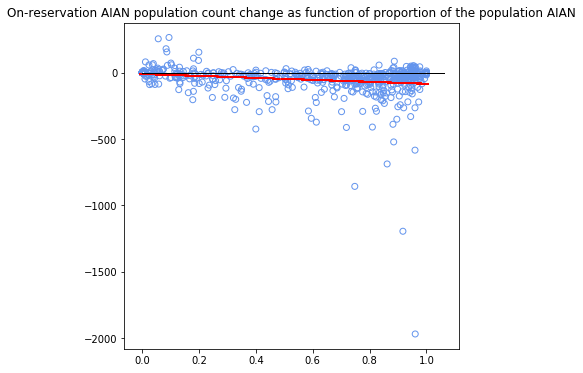

In [268]:
# plot preds
x = res_level_aian[["aian_prop_SF"]]
y = res_level_aian[["count_diff"]] 
z = res_level_aian[["aian_prop_SF"]]*res_bias_aian_res_prop_m+res_bias_aian_res_prop_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '_')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('On-reservation AIAN population count change as function of proportion of the population AIAN')

plt.show()

# asian rural bias

In [247]:
#is there a similar relationship for urban/rural asian alone bias?
rural_county_level['asian_count_diff'] = rural_county_level['P0030005_DP'] - rural_county_level['P0030005_SF']
rural_county_level['total_count_diff'] = rural_county_level['P0010001_DP'] - rural_county_level['P0010001_SF']
rural_county_level['prop_asian_SF'] = rural_county_level['P0030005_SF'] / rural_county_level['P0010001_SF']
rural_county_level['prop_asian_DP'] = rural_county_level['P0030005_DP'] / rural_county_level['P0010001_DP']

In [279]:
#rural asian bias
#exluding all rows where proportion is 0/0
X = rural_county_level[['P0030005_SF']]
y = rural_county_level[['asian_count_diff']]
rural_asian_size = linear_model.LinearRegression()
model = rural_asian_size.fit(X,y)

In [280]:
rural_asian_size_b = rural_asian_size.intercept_[0]
rural_asian_size_m = rural_asian_size.coef_[0]
print(f'''intercept: ,{rural_asian_size_b},
     coef: ,{rural_asian_size_m}''')

intercept: ,9.69617423895939,
     coef: ,[0.12698103]


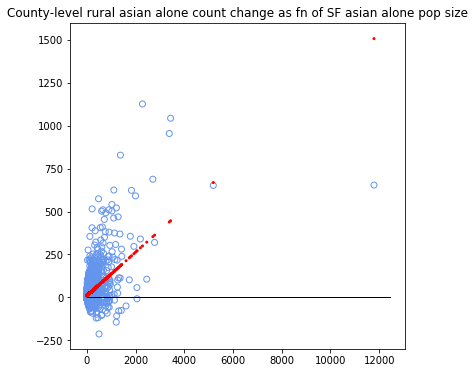

In [283]:
# plot preds
x = rural_county_level[["P0030005_SF"]]
y = rural_county_level[["asian_count_diff"]] 
z = rural_county_level[["P0030005_SF"]]*rural_asian_size_m+rural_asian_size_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('County-level rural asian alone count change as fn of SF asian alone pop size')

plt.show()

In [294]:
#rural asian bias
#exluding all rows where proportion is 0/0
X = rural_county_level[['P0010001_SF']]
y = rural_county_level[['asian_count_diff']]
rural_asian_total_size = linear_model.LinearRegression()
model = rural_asian_total_size.fit(X,y)

In [299]:
rural_asian_total_size_b = rural_asian_total_size.intercept_[0]
rural_asian_total_size_m = rural_asian_total_size.coef_[0]
print(f'''intercept: ,{rural_asian_total_size_b},
     coef: ,{rural_asian_total_size_m}''')

intercept: ,-6.034751871563525,
     coef: ,[0.0016788]


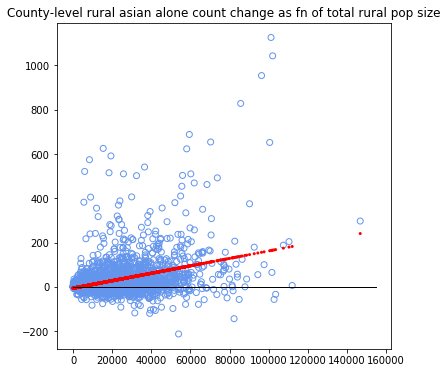

In [301]:
# plot preds
x = rural_county_level[["P0010001_SF"]]
y = rural_county_level[["asian_count_diff"]] 
z = rural_county_level[["P0010001_SF"]]*rural_asian_total_size_m+rural_asian_total_size_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('County-level rural asian alone count change as fn of total rural pop size')

plt.show()

In [300]:
# vars to try
# AIANHH, geographic location, % urban? if crosses state lines? %s and counts of other races?
# proportion of county rural & proportion of {some geo level (which?)} reservation

In [302]:
# add correlation matrix

In [308]:
rural_county_level.shape

(3128, 22)

In [309]:
urban_county_level.shape

(2440, 22)

In [314]:
county_level_ur = pd.merge(rural_county_level,
                       urban_county_level,
                       left_on=['STATE', 'COUNTY'],
                       right_on=['STATE', 'COUNTY'],
                       suffixes=('_r', '_u'))

In [316]:
county_level_ur.shape

(2426, 44)

In [317]:
county_level_ur.columns

Index(['P0030001_SF_r', 'P0030002_SF_r', 'P0030003_SF_r', 'P0030004_SF_r',
       'P0030005_SF_r', 'P0030006_SF_r', 'P0030007_SF_r', 'P0030008_SF_r',
       'P0010001_SF_r', 'P0030001_DP_r', 'P0030002_DP_r', 'P0030003_DP_r',
       'P0030004_DP_r', 'P0030005_DP_r', 'P0030006_DP_r', 'P0030007_DP_r',
       'P0030008_DP_r', 'P0010001_DP_r', 'asian_count_diff_r',
       'total_count_diff_r', 'prop_asian_SF_r', 'prop_asian_DP_r',
       'P0030001_SF_u', 'P0030002_SF_u', 'P0030003_SF_u', 'P0030004_SF_u',
       'P0030005_SF_u', 'P0030006_SF_u', 'P0030007_SF_u', 'P0030008_SF_u',
       'P0010001_SF_u', 'P0030001_DP_u', 'P0030002_DP_u', 'P0030003_DP_u',
       'P0030004_DP_u', 'P0030005_DP_u', 'P0030006_DP_u', 'P0030007_DP_u',
       'P0030008_DP_u', 'P0010001_DP_u', 'asian_count_diff_u',
       'total_count_diff_u', 'prop_asian_SF_u', 'prop_asian_DP_u'],
      dtype='object')

In [325]:
county_level_ur['prop_rural_SF'] = county_level_ur['P0010001_SF_r'] / ( county_level_ur['P0010001_SF_r'] +  county_level_ur['P0010001_SF_u'])

In [327]:
county_level_ur.prop_rural_SF.head

<bound method NDFrame.head of STATE  COUNTY
1      1         0.420022
       3         0.422791
       5         0.677896
       7         0.683526
       9         0.899515
                   ...   
56     37        0.109163
       39        0.464309
       41        0.430959
       43        0.359545
       45        0.545366
Name: prop_rural_SF, Length: 2426, dtype: float64>

In [328]:
county_level_ur.asian_count_diff_r.head

<bound method NDFrame.head of STATE  COUNTY
1      1          10
       3         101
       5          39
       7           3
       9          45
                ... 
56     37         25
       39         22
       41         -4
       43         -7
       45         -9
Name: asian_count_diff_r, Length: 2426, dtype: int64>

In [329]:
#rural asian bias as function of proportion of county rural
X = county_level_ur[['prop_rural_SF']]
y = county_level_ur[['asian_count_diff_r']]
rural_aisan_prop_rural= linear_model.LinearRegression()
model = rural_aisan_prop_rural.fit(X,y)

In [330]:
rural_aisan_prop_rural_b = rural_aisan_prop_rural.intercept_[0]
rural_aisan_prop_rural_m = rural_aisan_prop_rural.coef_[0]
print(f'''intercept: ,{rural_aisan_prop_rural_b},
     coef: ,{rural_aisan_prop_rural_m}''')

intercept: ,87.33586984350816,
     coef: ,[-116.56368668]


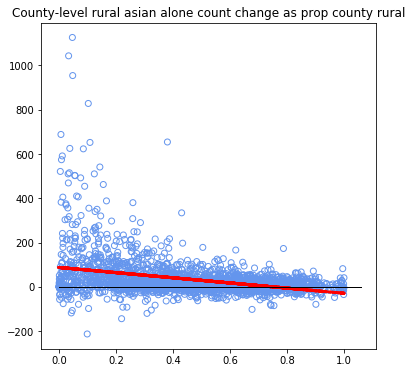

In [362]:
# plot preds
x = county_level_ur[['prop_rural_SF']]
y = county_level_ur[['asian_count_diff_r']]
z = county_level_ur[['prop_rural_SF']]*rural_aisan_prop_rural_m+rural_aisan_prop_rural_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('County-level rural asian alone count change as prop county rural')

plt.show()

In [336]:
county_level_ur.columns

Index(['P0030001_SF_r', 'P0030002_SF_r', 'P0030003_SF_r', 'P0030004_SF_r',
       'P0030005_SF_r', 'P0030006_SF_r', 'P0030007_SF_r', 'P0030008_SF_r',
       'P0010001_SF_r', 'P0030001_DP_r', 'P0030002_DP_r', 'P0030003_DP_r',
       'P0030004_DP_r', 'P0030005_DP_r', 'P0030006_DP_r', 'P0030007_DP_r',
       'P0030008_DP_r', 'P0010001_DP_r', 'asian_count_diff_r',
       'total_count_diff_r', 'prop_asian_SF_r', 'prop_asian_DP_r',
       'P0030001_SF_u', 'P0030002_SF_u', 'P0030003_SF_u', 'P0030004_SF_u',
       'P0030005_SF_u', 'P0030006_SF_u', 'P0030007_SF_u', 'P0030008_SF_u',
       'P0010001_SF_u', 'P0030001_DP_u', 'P0030002_DP_u', 'P0030003_DP_u',
       'P0030004_DP_u', 'P0030005_DP_u', 'P0030006_DP_u', 'P0030007_DP_u',
       'P0030008_DP_u', 'P0010001_DP_u', 'asian_count_diff_u',
       'total_count_diff_u', 'prop_asian_SF_u', 'prop_asian_DP_u',
       'prop_rural_SF'],
      dtype='object')

In [364]:
county_level_ur['pct_change_asian_rural'] = county_level_ur['P0030005_DP_r'] / county_level_ur['P0030005_SF_r']

In [365]:
county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural!=np.inf)]['pct_change_asian_rural'].describe()

count    2390.000000
mean        1.382216
std         1.253050
min         0.000000
25%         0.938474
50%         1.189915
75%         1.533640
max        27.000000
Name: pct_change_asian_rural, dtype: float64

In [366]:
#rural asian pct bias as function of proportion of county rural
X = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural!=np.inf)][['prop_rural_SF']]
y = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural!=np.inf)][['pct_change_asian_rural']]
pct_change_rural_aisan_prop_rural= linear_model.LinearRegression()
model = pct_change_rural_aisan_prop_rural.fit(X,y)

In [367]:
pct_change_rural_aisan_prop_rural_b = pct_change_rural_aisan_prop_rural.intercept_[0]
pct_change_rural_aisan_prop_rural_m = pct_change_rural_aisan_prop_rural.coef_[0]
print(f'''intercept: ,{pct_change_rural_aisan_prop_rural_b},
     coef: ,{pct_change_rural_aisan_prop_rural_m}''')

intercept: ,1.630148557667134,
     coef: ,[-0.52099038]


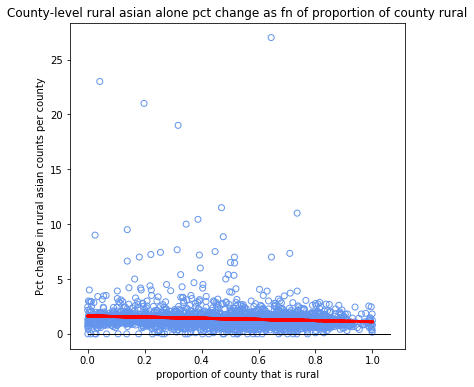

In [369]:
# plot preds
x = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural!=np.inf)][['prop_rural_SF']]
y = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural!=np.inf)][['pct_change_asian_rural']]
z = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural!=np.inf)][['prop_rural_SF']]*pct_change_rural_aisan_prop_rural_m+pct_change_rural_aisan_prop_rural_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

plt.xlabel('proportion of county that is rural')
plt.ylabel('Pct change in rural asian counts per county')
plt.title('County-level rural asian alone pct change as fn of proportion of county rural')

plt.show()

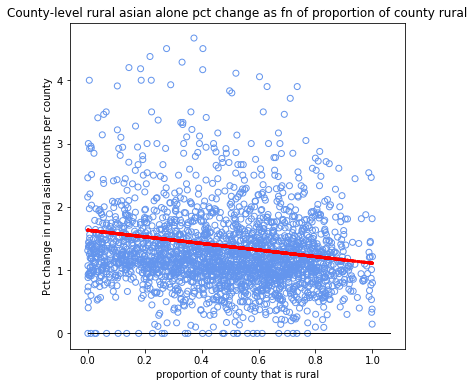

In [371]:
# plot preds
x = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural<5)][['prop_rural_SF']]
y = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural<5)][['pct_change_asian_rural']]
z = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural<5)][['prop_rural_SF']]*pct_change_rural_aisan_prop_rural_m+pct_change_rural_aisan_prop_rural_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

plt.xlabel('proportion of county that is rural')
plt.ylabel('Pct change in rural asian counts per county')
plt.title('County-level rural asian alone pct change as fn of proportion of county rural')

plt.show()